In [2]:
# import libary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [3]:
dataset_path = "./teaSicknessDataset"
dataset_dir = pathlib.Path(dataset_path)

In [4]:
# list of sub directory(class)
class_names = []
for x in os.walk(dataset_path):
    sub_dir = x[0]

    sub_dir_list = str(sub_dir).split('\\')
    if len(sub_dir_list) > 0:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)
class_names.pop(0)
print(class_names)

['algal leaf', 'Anthracnose', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [5]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class algal leaf: 452
Images in class Anthracnose: 400
Images in class bird eye spot: 400
Images in class brown blight: 452
Images in class gray light: 400
Images in class healthy: 292
Images in class red leaf spot: 572
Images in class white spot: 568


In [6]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 3536 files belonging to 8 classes.
Using 2829 files for training.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
dataset_dir,
validation_split=val_split,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=train_batch)

Found 3536 files belonging to 8 classes.
Using 707 files for validation.


In [9]:
dnn_model = Sequential()

In [10]:
imported_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=(224,224,3),
pooling='avg',classes=8,
weights='imagenet')

for layer in imported_model.layers:
    layer.trainable=False

In [11]:
dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(8, activation='softmax'))

In [12]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
dnn_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
reduce_lr =  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop =  EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [14]:
history = dnn_model.fit(
train_ds,
validation_data=test_ds,
epochs=50,
callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
23/23 [==============================] - 120s 5s/step - loss: 1.1559 - accuracy: 0.6451 - val_loss: 0.5122 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 127s 5s/step - loss: 0.3479 - accuracy: 0.8752 - val_loss: 0.3025 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 130s 6s/step - loss: 0.2155 - accuracy: 0.9343 - val_loss: 0.2617 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 134s 6s/step - loss: 0.1777 - accuracy: 0.9420 - val_loss: 0.2507 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 136s 6s/step - loss: 0.1267 - accuracy: 0.9615 - val_loss: 0.1669 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 137s 6s/step - loss: 0.0927 - accuracy: 0.9767 - val_loss: 0.2243 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - 138s 6s/step - loss: 0.0

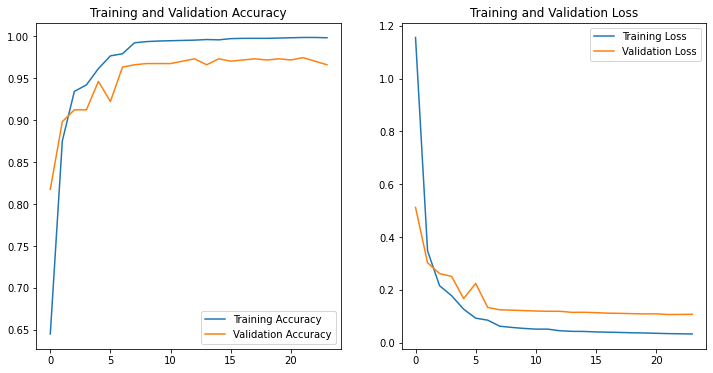

In [16]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(24)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
 [6 1 6 4 7 6 5 0 5 1 3 2 3 4 0 2 3 6 4 1 6 4 7 6 0 6 3 6 4 2 1 5 7 1 2 6 4
 3 5 2 0 6 4 4 7 4 2 4 2 7 5 7 7 7 4 5 4 6 7 3 7 6 0 6 6 4 2 6 3 7 6 3 7 2
 5 7 4 5 0 7 3 7 4 3 6 6 3 3 6 3 4 3 1 7 4 0 2 1 6 2 3 7 2 6 7 4 2 6 7 6 0
 2 1 1 1 6 6 2 4 2 0 5 6 7 1 6 0 6]
Labels:
 [6 1 6 4 7 6 5 0 5 1 3 2 3 4 0 2 3 6 4 1 6 4 7 6 0 6 3 6 4 2 1 5 7 1 2 6 4
 3 5 2 0 6 4 4 7 4 2 4 2 7 5 7 7 7 4 5 4 6 7 3 7 6 0 6 6 4 2 6 3 7 6 3 7 2
 5 7 4 5 4 7 3 7 4 3 6 6 3 3 6 3 4 3 1 7 4 0 2 1 6 2 3 7 2 6 7 4 2 6 7 6 0
 2 1 1 1 6 6 2 4 2 0 5 6 7 1 6 0 6]

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        15
           4       1.00      0.95      0.97        20
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        28
           7       1.

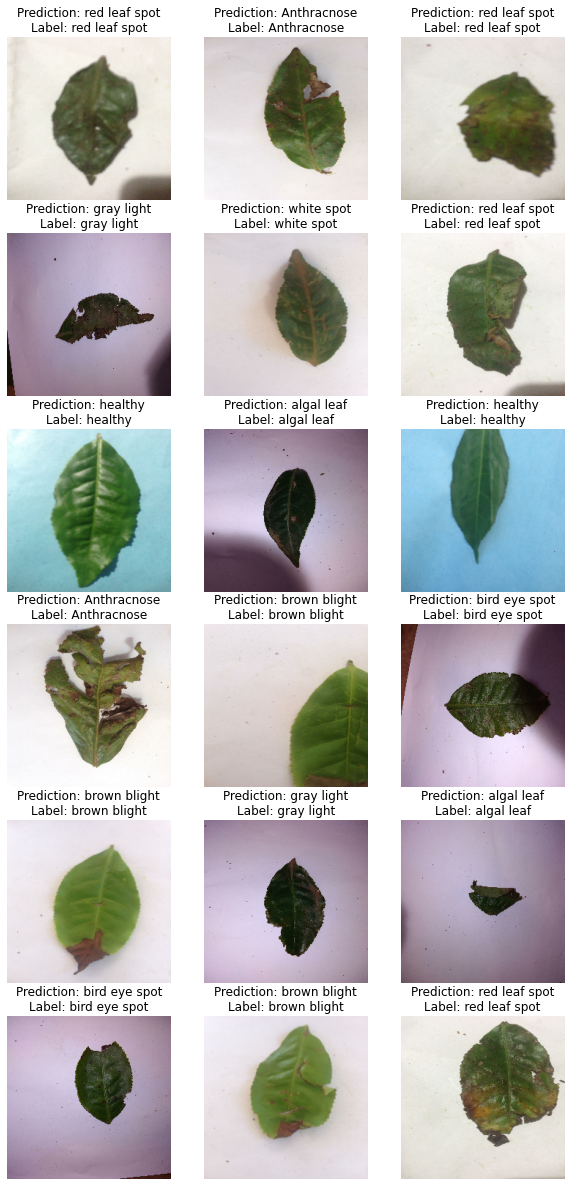

In [17]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = dnn_model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [18]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("historyResnetEarly.csv")
history_df.tail()

,loss,accuracy,val_loss,val_accuracy,lr
19,0.036593,0.997879,0.108779,0.973126,0.0001
20,0.035418,0.998233,0.109011,0.971711,0.0001
21,0.034169,0.998586,0.106509,0.974540,0.0001
22,0.033609,0.998586,0.106781,0.970297,0.0001
23,0.032809,0.998233,0.107356,0.966054,0.0001
